<h1 align="center">Análise Estatística e Predição de Aluguéis Residenciais em São Paulo</h1>

## 1. Introdução

...

## 2. Configuração do Ambiente

### 2.1. Importações

In [51]:
# Manipulação de dados
import numpy as np
import pandas as pd

# Visualização
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Estatística e diagnóstico
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Aprendizado de máquina 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### 2.2. Estilo de gráficos e formatação de valores

In [2]:
# Estilo dos gráficos
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('deep')

# Formatação de exibição de números
pd.set_option('display.float_format', '{:.2f}'.format)

### 2.3. Definições iniciais (Path e Seed) e carregamento

In [3]:
# Caminho para os dados
DATA_PATH = '../data/data.csv'

# Seed 
SEED = 42

# Carrega o DataFrame 'df' 
df = pd.read_csv(DATA_PATH)

## 3. Visão Geral e Inspeção dos Dados

### 3.1. Visão geral dos dados

In [4]:
# Exibe as primeiras 10 linhas do DataFrame 'df' 
df.head(10)

,address,district,area,bedrooms,garage,type,rent,total
0,Rua Herval,Belenzinho,21,1,0,Studio e kitnet,2400,2939
1,Avenida São Miguel,Vila Marieta,15,1,1,Studio e kitnet,1030,1345
2,Rua Oscar Freire,Pinheiros,18,1,0,Apartamento,4000,4661
3,Rua Júlio Sayago,Vila Ré,56,2,2,Casa em condomínio,1750,1954
4,Rua Barata Ribeiro,Bela Vista,19,1,0,Studio e kitnet,4000,4654
5,Rua Domingos Paiva,Brás,50,2,1,Apartamento,3800,4587
6,Rua Guararapes,Brooklin Paulista,72,2,1,Apartamento,3500,5187
7,Avenida Cásper Líbero,Centro,26,1,0,Studio e kitnet,1727,2244
8,Rua José Peres Campelo,Piqueri,32,2,0,Apartamento,1200,1592
9,Rua Guaperuvu,Vila Aricanduva,36,1,0,Apartamento,1200,1501


In [5]:
# Exibe o número de linhas e colunas do DataFrame 'df'
print(f"Número de linhas: {df.shape[0]}.")
print(f"Número de colunas: {df.shape[1]}.")

Número de linhas: 11657.
Número de colunas: 8.


In [6]:
# Exibe as informações sobre os dados 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11657 entries, 0 to 11656
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   address   11657 non-null  object
 1   district  11657 non-null  object
 2   area      11657 non-null  int64 
 3   bedrooms  11657 non-null  int64 
 4   garage    11657 non-null  int64 
 5   type      11657 non-null  object
 6   rent      11657 non-null  int64 
 7   total     11657 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 728.7+ KB


### 3.2. Estatísticas descritivas iniciais

In [7]:
# Exibe as estatísticas descritivas do DataFrame 'df'
df.describe()

,area,bedrooms,garage,rent,total
count,11657.00,11657.00,11657.00,11657.00,11657.00
mean,84.66,1.97,1.06,3250.81,4080.03
std,74.02,0.93,1.13,2650.71,3352.48
min,0.00,0.00,0.00,500.00,509.00
25%,40.00,1.00,0.00,1590.00,1996.00
50%,60.00,2.00,1.00,2415.00,3057.00
75%,96.00,3.00,2.00,3800.00,4774.00
max,580.00,6.00,6.00,25000.00,28700.00


### Considerações:

- `area`: Apresenta média de 84,66 m², com um desvio padrão elevado (74,02), indicando grande variabilidade no tamanho dos imóveis. A mediana de 60 m² e a presença de valores máximos de até 580 m² reforçam a existência de outliers e uma distribuição assimétrica à direita. O valor mínimo de 0 m² é suspeito, podendo indicar dados faltantes mal codificados, e deve ser investigado mais a fundo.

- `bedrooms`: A média de 1,97 quartos e a mediana de 2 indicam que a maior parte dos imóveis possui entre 1 e 2 quartos. O valor máximo de 6 é plausível, no caso de imóveis de alto padrão, mas pouco frequente, enquanto o valor mínimo 0 também requer atenção, podendo indicar estúdios ou registros inconsistentes.

- `garage`: A média de 1,06 vaga com desvio padrão de 1,13 revela uma distribuição concentrada em 1 vaga, o que é compatível com a realidade urbana. O valor 0 pode refletir imóveis mais compactos ou localizados em regiões centrais, enquanto o valor máximo de 6 é extremamente atípico e também deve ser investigado quanto à sua validade.

- `rent`: O valor do aluguel apresenta uma média de R$3.250,81, com desvio padrão de R$2.650,71, evidenciando alta dispersão. A mediana de R$2.415 é significativamente inferior à média, sugerindo forte assimetria à direita. O aluguel máximo, de R$25.000, configura um outlier evidente, provavelmente associado a imóveis de alto padrão em localizações privilegiadas.

- `total`: Como esperado, `total` apresenta valores ligeiramente superiores aos de `rent`, com média de R$4.080,03 e mediana de R$3.057,00. A semelhança no comportamento estatístico entre ambas reforça a relação direta, embora os encargos adicionais introduzam variação extra que será analisada separadamente.

### 3.3. Análise de valores ausentes e duplicatas

In [8]:
print(f"Duplicatas: {df.duplicated().sum()}")
print(f"Valores ausentes: {df.isnull().sum()}")

Duplicatas: 0
Valores ausentes: address     0
district    0
area        0
bedrooms    0
garage      0
type        0
rent        0
total       0
dtype: int64


Na ausência de valores nulos e registros duplicados, avançamos para a etapa de análise exploratória, na próxima seção.

### 3.4. Cardinalidade

In [9]:
# Exibe o número de valores únicos por coluna
df.nunique().sort_values()

type           4
bedrooms       7
garage         7
area         381
district    1199
rent        1662
address     5348
total       5571
dtype: int64

### 3.5. Frequência das categorias

In [10]:
# Frequência das categorias nas variáveis categóricas
for col in df.select_dtypes(include = ['object']).columns:
    print(f'\n{col.upper()}')
    print(df[col].value_counts())


ADDRESS
address
Rua da Consolação                          49
Rua Bela Cintra                            47
Avenida Brigadeiro Luís Antônio            36
Avenida Ipiranga                           32
Avenida Nove de Julho                      29
                                           ..
Rua Guaperuvu                               1
Rua Júlio Sayago                            1
São José                                    1
Avenida Doutor Alberto de Oliveira Lima     1
Avenida Dona Helena Pereira de Moraes       1
Name: count, Length: 5348, dtype: int64

DISTRICT
district
Bela Vista              352
Vila Mariana            232
Jardim Paulista         220
Centro                  178
Pinheiros               159
                       ... 
Nova Aldeinha             1
Pacaembu.                 1
Parque Munhoz             1
Jardim dos Prados         1
Bolsão do Interlagos      1
Name: count, Length: 1199, dtype: int64

TYPE
type
Apartamento           7194
Casa                  2841
Studi

### 3.6. Análise de valores ausentes e duplicatas

In [11]:
# Verificação de valores ausentes e duplicatas
missing_dict = df.isnull().sum().to_dict()

print("Total de valores ausentes por coluna:")
for col, missing in missing_dict.items():
    print(f"- {col}: {missing}")

print(f"\nTotal de linhas duplicadas: {df.duplicated().sum()}")

Total de valores ausentes por coluna:
- address: 0
- district: 0
- area: 0
- bedrooms: 0
- garage: 0
- type: 0
- rent: 0
- total: 0

Total de linhas duplicadas: 0


Na ausência de valores nulos e registros duplicados, avançamos para a etapa de análise exploratória. 

## 4. Análise Exploratória dos Dados

Nesta seção, buscamos compreender as distribuições das variáveis, bem como as relações entre os atributos e a variável-alvo `rent`, por meio de visualizações gráficas e análises estatísticas. Esses insights exploratórios serão fundamentais para orientar as decisões na etapa de modelagem preditiva.


### 4.1. Distribuições das variáveis numéricas 

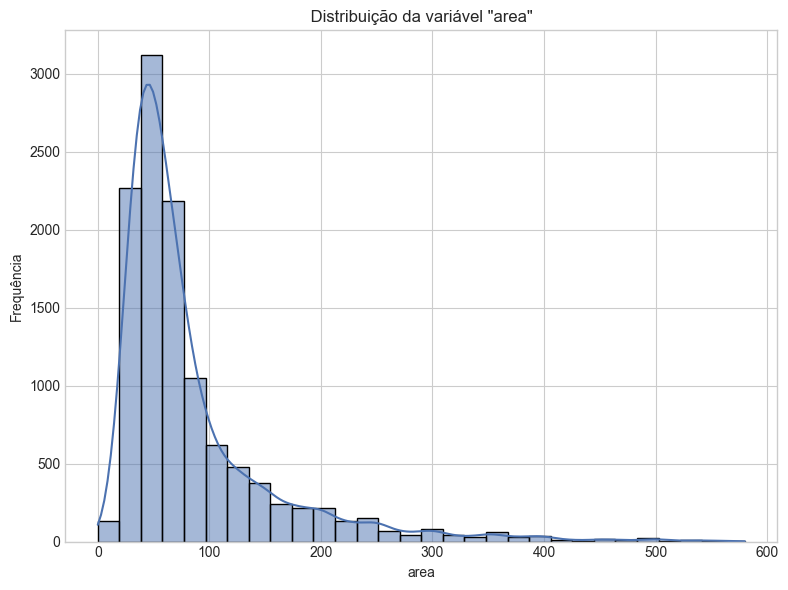

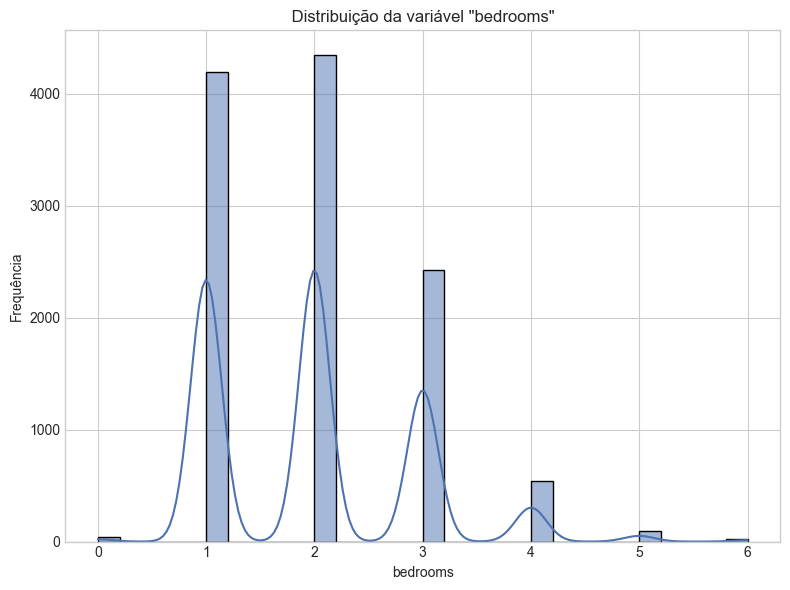

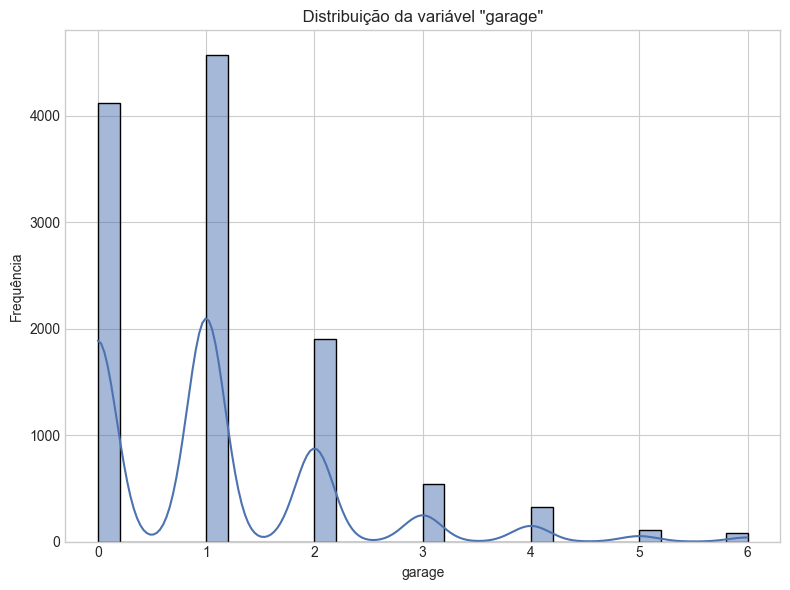

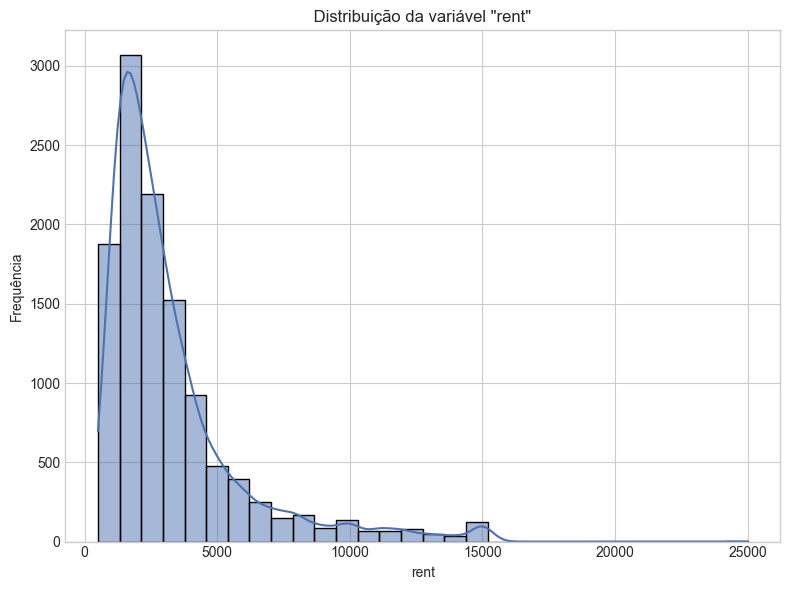

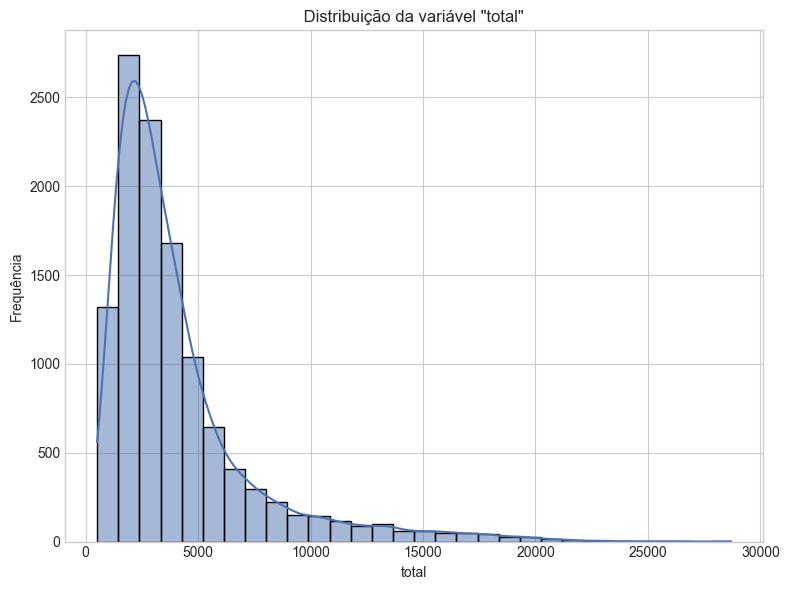

In [12]:
# Para cada coluna numérica, plota um histograma com KDE
num_cols = df.select_dtypes(include = ['number']).columns

for col in num_cols:
    plt.figure(figsize = (8, 6))
    sns.histplot(df[col], kde = True, bins = 30)
    plt.title(f' Distribuição da variável "{col}" ')
    plt.xlabel(col)
    plt.ylabel('Frequência')
    plt.tight_layout()
    plt.show()

### Considerações:

- `area`: A variável `area` apresenta uma distribuição fortemente assimétrica à direita, com o pico de densidade entre 40 m² e 70 m². Observa-se que aproximadamente 75% dos imóveis possuem área inferior a 96 m² (3º quartil), com a mediana situada em 60 m². A média, no entanto, é significativamente maior (84,66 m²), o que confirma a presença de valores extremos que puxam a média para cima.  
A cauda longa da distribuição se estende até 580 m², com diversos valores acima de 200 m² que podem ser classificados como outliers. Além disso, há registros com área igual a 0, os quais são estatisticamente incoerentes e devem ser investigados, pois podem indicar dados ausentes mal codificados.  

- `bedrooms`: A variável apresenta picos bem definidos em 1, 2 e 3 quartos, o que é esperado e condiz com a tipologia predominante de imóveis residenciais. Imóveis com mais de 4 quartos são raros, compondo a cauda da distribuição. Como essa variável tem baixa cardinalidade e assume valores discretos, pode ser tratada como ordinal, sendo adequada tanto para modelagem direta quanto para codificação categórica.

- `garage`: Assim como `bedrooms`, a variável `garage` apresenta distribuição discreta, com picos em 0, 1 e 2 vagas. Há uma concentração significativa de imóveis sem garagem, o que pode refletir características urbanas de regiões centrais e menor disponibilidade de espaço para veículos. Para fins de modelagem, é importante avaliar o impacto dessa variável sobre a variável-alvo `rent`, bem como possíveis interações com atributos como `type` e `area`.

- `rent`: A variável apresenta uma distribuição assimétrica à direita, com maior densidade concentrada abaixo de R$5.000 e uma cauda longa que se estende até valores superiores a R$20.000. Esse comportamento é característico do mercado imobiliário, no qual poucos imóveis de alto padrão elevam a média e aumentam a dispersão. A mediana (R$2.415, conforme estatísticas descritivas) é consideravelmente inferior à média (R$3.250), o que reforça a assimetria.  
A variável será utilizada como variável-alvo neste projeto.

- `total`: A variável representa o custo mensal total do imóvel e exibe padrão de distribuição semelhante ao da variável `rent`, porém com valores sistematicamente mais altos devido à inclusão de encargos fixos, como condomínio e IPTU, que não estão explicitados no conjunto de dados. A média é de R$4.080 e a mediana é de R$3.057, novamente indicando assimetria à direita. Os valores mais altos, que ultrapassam R$28.000, configuram outliers e devem ser analisados com atenção. 

### 4.2. Análise dos encargos

A variável `encargos` é definida como a diferença entre o custo total mensal (`total`) e o valor do aluguel (`rent`). O objetivo por trás dessa variável é capturar os custos adicionais que o inquilino deve considerar além do aluguel, como condomínio e IPTU.  

Embora esses componentes não estejam detalhados individualmente no conjunto de dados, sua influência é capturada indiretamente na variável `total`. Ao decompor essa relação, conseguimos entender melhor a composição do custo total e avaliar se os encargos seguem algum padrão ou se estão associados a características específicas dos imóveis, como localização, área ou tipo.  

Essa variável também permite identificar variações relevantes entre imóveis com aluguel semelhante, oferecendo uma perspectiva complementar à análise da variável-alvo e auxiliando na modelagem preditiva.

In [13]:
# Cria a variável 'encargos'
df['encargos'] = df['total'] - df['rent']

In [14]:
# Exibe as estatísticas descritivas da nova variável 'encargos'
df['encargos'].describe()

count   11657.00
mean      829.22
std       938.91
min         9.00
25%       268.00
50%       577.00
75%      1016.00
max     13700.00
Name: encargos, dtype: float64

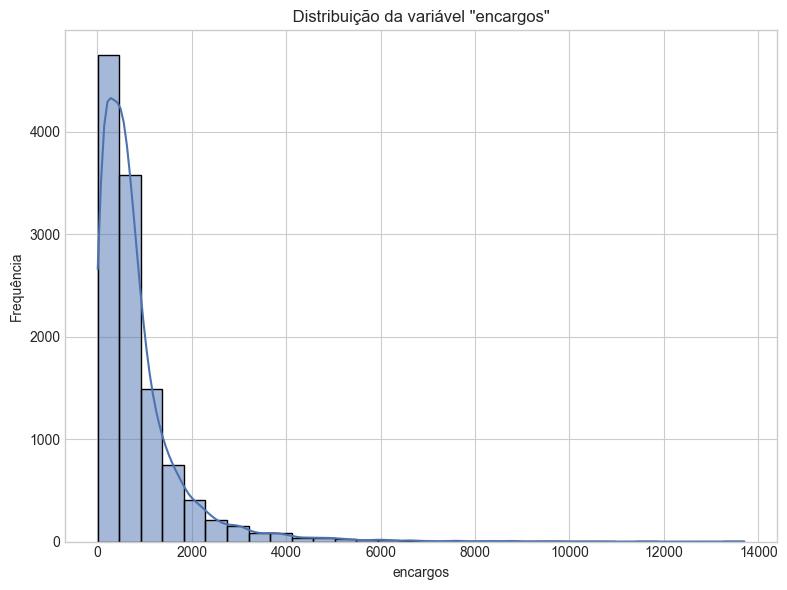

In [15]:
plt.figure(figsize = (8, 6))
sns.histplot(df['encargos'], kde = True, bins = 30)
plt.title(f' Distribuição da variável "{'encargos'}" ')
plt.xlabel('encargos')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

### Considerações:

Novamente, percebe-se uma distribuição assimétrica à direita, com a maioria dos imóveis apresentando encargos inferiores a R$900. A mediana é de R$577, valor significativamente inferior à média de R$829, o que reforça a presença de valores extremos que elevam a média. O desvio padrão de R$938,91 indica alta variabilidade. Casos com encargos acima de R$5.000 são raros e configuram outliers, sendo o valor máximo observado R$13.700. Esses valores devem ser avaliados com atenção, pois podem influenciar negativamente os modelos. 

### 4.3. Análise de outliers

Nesta seção, utilizamos boxplots para identificar valores atípicos nas variáveis numéricas contínuas. A detecção de outliers é importante para avaliar possíveis distorções na distribuição dos dados e seu impacto na modelagem preditiva.


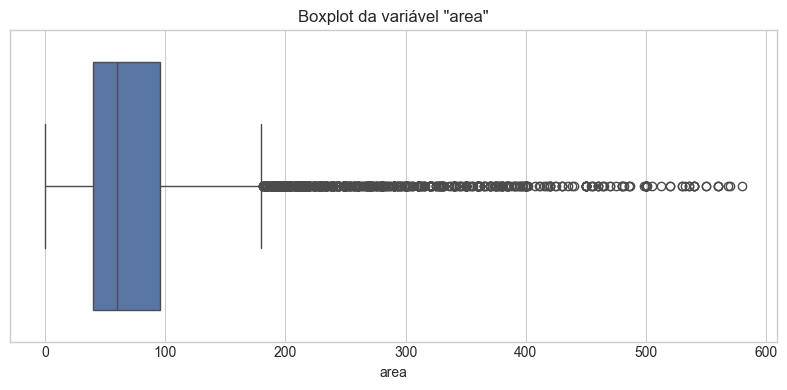

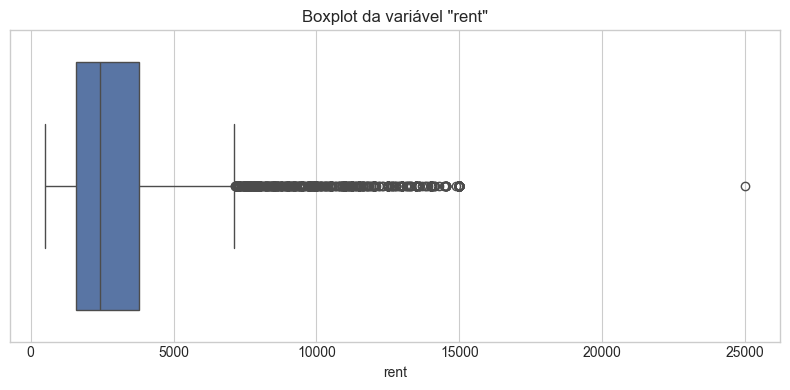

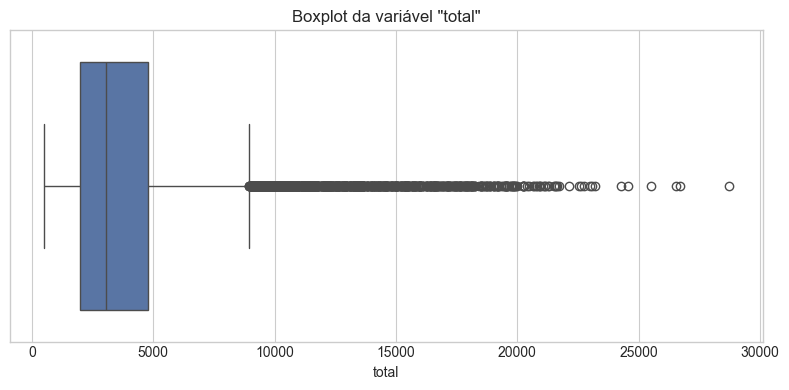

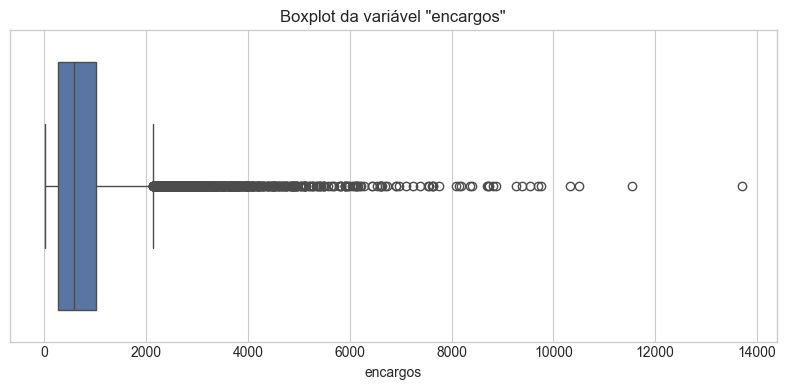

In [16]:
# Plota boxplots para as variáveis contínuas
continuous_cols = ['area', 'rent', 'total', 'encargos']

for col in continuous_cols:
    plt.figure(figsize = (8, 4))
    sns.boxplot(x = df[col])
    plt.title(f'Boxplot da variável "{col}"')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

In [17]:
# Função para detectar outliers usando o método IQR
def outlier_detection_iqr(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lim_inf = q1 - 1.5 * iqr
    lim_sup = q3 + 1.5 * iqr
    outliers = series[(series < lim_inf) | (series > lim_sup)]
    return len(outliers), round(len(outliers) / len(series) * 100, 2), lim_inf, lim_sup

for col in continuous_cols:
    n_outliers, perc, lim_inf, lim_sup = outlier_detection_iqr(df[col])
    print(f'{col}: {n_outliers} outliers ({perc}% do total), com limite inferior {lim_inf} e limite superior {lim_sup}.')

area: 1063 outliers (9.12% do total), com limite inferior -44.0 e limite superior 180.0.
rent: 952 outliers (8.17% do total), com limite inferior -1725.0 e limite superior 7115.0.
total: 943 outliers (8.09% do total), com limite inferior -2171.0 e limite superior 8941.0.
encargos: 807 outliers (6.92% do total), com limite inferior -854.0 e limite superior 2138.0.


### 4.4. Análise de correlações

Nesta subseção, avaliamos a correlação linear entre as variáveis numéricas por meio da matriz de correlação de Pearson.

In [18]:
cols_corr = continuous_cols + ['garage', 'bedrooms']

In [19]:
corr_matrix = df[cols_corr].corr()

In [20]:
# Exibe a matriz de correlação 
corr_matrix

,area,rent,total,encargos,garage,bedrooms
area,1.00,0.67,0.65,0.44,0.73,0.73
rent,0.67,1.00,0.98,0.67,0.62,0.53
total,0.65,0.98,1.00,0.81,0.62,0.53
encargos,0.44,0.67,0.81,1.00,0.46,0.38
garage,0.73,0.62,0.62,0.46,1.00,0.66
bedrooms,0.73,0.53,0.53,0.38,0.66,1.00


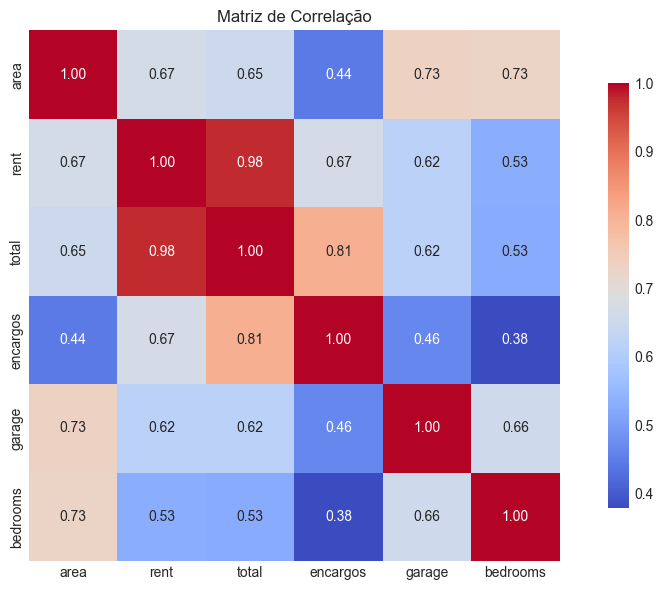

In [21]:
# Heatmap da matriz de correlação
plt.figure(figsize = (10, 6))
sns.heatmap(corr_matrix, annot = True, fmt = '.2f', cmap = 'coolwarm', square = True, cbar_kws = {'shrink': .8})
plt.title('Matriz de Correlação')
plt.tight_layout()
plt.show()


### Considerações:

A variável `total` apresenta correlação muito forte com `rent` (0,98), o que era esperado, dado que `total` é composto por `rent` somado aos `encargos`.

A variável `encargos` se correlaciona fortemente com `total` (0,81) e moderadamente com `rent` (0,67), refletindo a estrutura dos dados: imóveis com aluguéis mais altos tendem a apresentar encargos mais elevados.

As variáveis `area`, `bedrooms` e `garage` exibem correlações moderadas com `rent` (entre 0,53 a 0,65), sugerindo que imóveis maiores, com mais quartos e garagens, tendem a apresentar valores de aluguel mais altos.

Além disso, observa-se uma correlação alta entre `area`, `bedrooms` e `garage` (entre 0,66 e 0,73), o que pode indicar uma leve redundância entre essas variáveis, mas não a ponto de configurar colinearidade severa.

### 4.5. Testes de hipótese

Nesta subseção, buscamos investigar estatisticamente se o tipo de imóvel (`type`) exerce influência significativa sobre o valor do aluguel (`rent`). Para isso, aplicamos o teste ANOVA (Análise de Variância), apropriado para comparar médias entre mais de dois grupos independentes. 

As hipóteses do teste são:
- $\text{H}_0$ (hipótese nula): As médias de `rent` são iguais para todos os tipos de imóvel;
- $\text{H}_1$ (hipótese alternativa): Pelo menos uma média de `rent` é diferente entre os tipos de imóvel.

A seguir, agrupamos os dados por tipo de imóvel e aplicamos o teste.

In [22]:
# Verifica os tipos únicos
print("Tipos de imóvel:", df['type'].unique())

# Agrupa os valores de 'total' por tipo de imóvel
grupos_rent = [df[df['type'] == tipo]['rent'] for tipo in df['type'].unique()]

# ANOVA
f_stat, p_val = stats.f_oneway(*grupos_rent)

print(f'Estatística F: {f_stat:.2f}')
print(f'p-valor: {p_val:.4f}')

Tipos de imóvel: ['Studio e kitnet' 'Apartamento' 'Casa em condomínio' 'Casa']
Estatística F: 100.57
p-valor: 0.0000


Como o p-valor do teste ANOVA foi significativamente inferior ao nível de significância usual de 5%, rejeitamos a hipótese nula. Isso indica que existem diferenças estatisticamente significativas nas médias de `rent` entre os diferentes tipos de imóvel.

Para identificar quais pares de grupos apresentam diferenças relevantes, aplicamos o teste post-hoc de Tukey (HSD), que compara as médias duas a duas.

                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
      group1             group2        meandiff  p-adj    lower      upper    reject
------------------------------------------------------------------------------------
       Apartamento               Casa    115.022 0.1943   -33.9956   264.0396  False
       Apartamento Casa em condomínio   555.6492 0.0065     115.25   996.0483   True
       Apartamento    Studio e kitnet -1229.0772    0.0 -1426.6534  -1031.501   True
              Casa Casa em condomínio   440.6272 0.0585   -10.5757   891.8301  False
              Casa    Studio e kitnet -1344.0992    0.0 -1564.7098 -1123.4886   True
Casa em condomínio    Studio e kitnet -1784.7264    0.0 -2254.2093 -1315.2435   True
------------------------------------------------------------------------------------


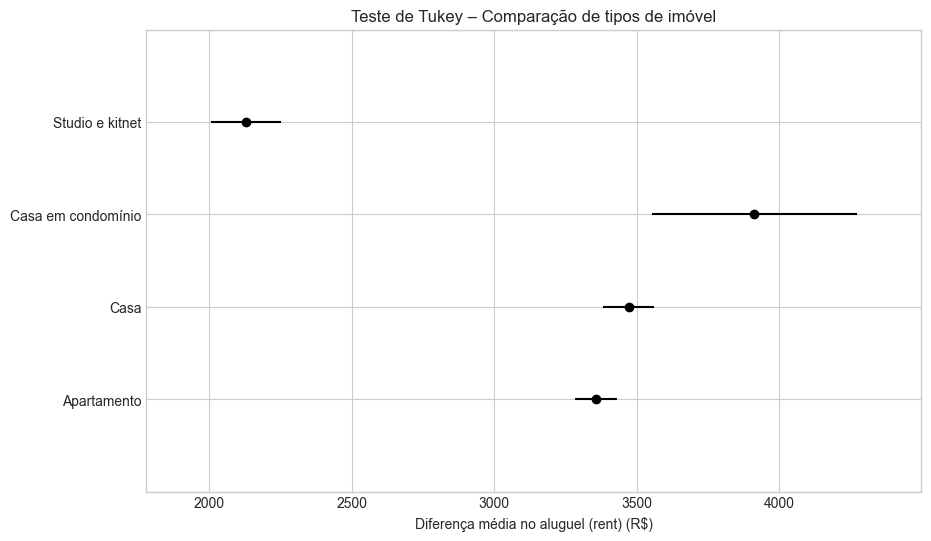

In [23]:
# Importa o teste de Tukey HSD
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Teste de Tukey HSD
tukey = pairwise_tukeyhsd(endog = df['rent'], groups = df['type'], alpha = 0.05)

# Exibe a tabela de resultados
print(tukey)

# Visualiza os intervalos de confiança das diferenças entre grupos
tukey.plot_simultaneous()
plt.title('Teste de Tukey – Comparação de tipos de imóvel')
plt.xlabel('Diferença média no aluguel (rent) (R$)')
plt.show()

O teste de Tukey confirmou que:

- "Studio e kitnet" tem custo total significativamente inferior aos demais;
- "Casa" difere significativamente de "Apartamento" e "Casa em condomínio";
- A comparação entre "Apartamento" e "Casa em condomínio" não apresentou diferença significativa.

Esses resultados mostram que o tipo de imóvel tem impacto direto sobre o custo total e justificam a inclusão da variável `type` como preditora nos modelos de regressão.

## 5. Pré-processamento dos Dados

Nesta seção, realizamos o pré-processamento dos dados para preparar o conjunto para a modelagem preditiva. 

### 5.1. Tratamento da variável `district`

Notou-se que, após a realização do One-Hot Encoding (OHE), o número de colunas do dataset aumentou consideravelmente, de 8 para 1206. Esse crescimento se deve principalmente à alta cardinalidade da variável `district`, que apresenta uma grande quantidade de categorias distintas correspondentes aos bairros de São Paulo.  
Esse aumento na dimensionalidade pode acarretar problemas como overfitting, aumento do custo computacional e degradação da performance preditiva, especialmente em modelos lineares. Diante disso, foi feita uma análise com base na frequência de cada bairro, e os seguintes passos foram adotados:
- **Agrupamento de bairros menos frequentes**: Bairros com menos de 10 ocorrências foram agrupados em uma categoria única chamada `outros`, reduzindo a dimensionalidade e evitando a criação de colunas excessivas.
- **Seleção dos bairros mais frequentes**: Foram mantidos os 244 bairros com maior número de ocorrências, garantindo que as categorias mais representativas fossem preservadas.

Com essa abordagem, equilibrou-se a preservação da informação relevante com a necessidade de controle da complexidade do modelo, permitindo uma codificação categórica mais parcimoniosa e adequada ao problema preditivo.  
Adicionalmente, a variável `address` foi descartada por apresentar cardinalidade extremamente elevada, dificultando qualquer forma eficaz de codificação e não oferecendo, em sua forma bruta, contribuição substancial para a modelagem.

In [24]:
# Remove a coluna 'address' do DataFrame
df.drop(columns = ['address'], inplace = True)

In [25]:
# Verifica o número de distritos únicos
districts = df['district'].nunique()
districts 

1199

In [26]:
# Contagem de imóveis por distrito
district_counts = df['district'].value_counts() 
district_counts

district
Bela Vista              352
Vila Mariana            232
Jardim Paulista         220
Centro                  178
Pinheiros               159
                       ... 
Nova Aldeinha             1
Pacaembu.                 1
Parque Munhoz             1
Jardim dos Prados         1
Bolsão do Interlagos      1
Name: count, Length: 1199, dtype: int64

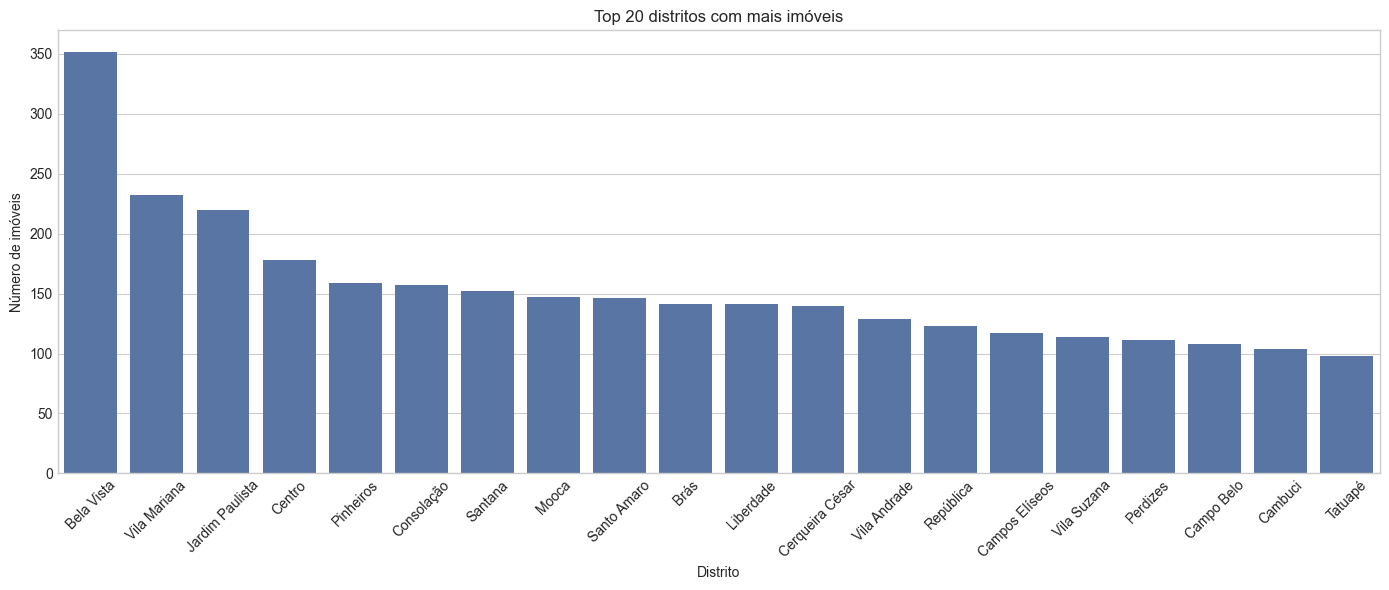

In [27]:
# Visualização dos 20 distritos com mais imóveis
top_districts = df['district'].value_counts().head(20).index

plt.figure(figsize = (14, 6))
sns.countplot(data = df[df['district'].isin(top_districts)], x = 'district', order = top_districts)
plt.title('Top 20 distritos com mais imóveis')
plt.xlabel('Distrito')
plt.ylabel('Número de imóveis')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

In [28]:
# Estatísticas descritivas de district_counts 
district_counts.describe()

count   1199.00
mean       9.72
std       23.21
min        1.00
25%        1.00
50%        3.00
75%        8.00
max      352.00
Name: count, dtype: float64

In [29]:
# Cria uma cópia do DataFrame para modelagem
df_model = df.copy()

# Define o limite mínimo de ocorrências
lim = 10

# Identifica distritos com ocorrências acima do limite
relevant_districts = district_counts[district_counts > lim].index

# Substitui distritos com poucas ocorrências por 'outros'
df_model['district'] = df_model['district'].apply(lambda x: x if x in relevant_districts else 'outros')

# Verifica o resultado
print(f"O número de distritos únicos após a substituição é: {df_model['district'].nunique()}.\n")
print(df_model['district'].value_counts())

O número de distritos únicos após a substituição é: 244.

district
outros                    2964
Bela Vista                 352
Vila Mariana               232
Jardim Paulista            220
Centro                     178
                          ... 
Jardim Cidade Pirituba      11
Jardim Taquaral             11
Vila São José               11
Vila Campo Grande           11
Vila Campanela              11
Name: count, Length: 244, dtype: int64


In [30]:
# Cria variáveis dummy para 'district' e 'type'
df_model = pd.get_dummies(df_model, columns = ['district', 'type'], drop_first = True, dtype = 'float')

In [31]:
# Exibe o shape do DataFrame 'df_model'
df_model.shape

(11657, 252)

Após a aplicação de `get_dummies()` com `drop_first = True` e a consolidação dos bairros menos frequentes na categoria `outros`, o número total de variáveis preditoras aumentou para 251. Esse crescimento decorre principalmente da expansão da variável categórica `district`, que passou a representar apenas os bairros com pelo menos 10 ocorrências (mais de 240 categorias relevantes), além da codificação de `type`.  

Apesar do aumento na dimensionalidade, a estratégia adotada evita redundâncias e mantém o foco nas categorias mais representativas, equilibrando complexidade e interpretabilidade do modelo. Em contraste com a primeira abordagem, na qual a aplicação direta do OHE gerou 1206 colunas devido à alta cardinalidade de `district`, o método atual resulta em uma estrutura mais enxuta e gerenciável, favorecendo tanto a performance computacional quanto a estabilidade dos modelos.

### 5.2. Feature engineering

Nesta etapa, foram criadas novas variáveis a partir das existentes para enriquecer o conjunto de dados e potencializar a capacidade preditiva dos modelos. As seguintes variáveis foram adicionadas:
- `price_per_m2`: Representa o valor do aluguel por metro quadrado, calculado como a razão `rent / area`. Essa métrica é útil para comparar imóveis de diferentes tamanhos e identificar aqueles com melhor relação custo-benefício;
- `has_garage`: Variável binária que indica se o imóvel possui garagem (1) ou não (0). Essa variável pode capturar a influência da disponibilidade de vagas sobre o valor do aluguel, especialmente em áreas urbanas onde o espaço para estacionamento é limitado;
- `is_large`: Variável binária que indica se o imóvel é considerado grande (1) ou não (0), baseando-se no número de quartos e na área. Imóveis com 3 ou mais quartos são classificados como grandes, bem como imóveis com área igual ou acima de 100 m², enquanto os demais são considerados pequenos.

In [32]:
# Cria a variável 'price_per_m2', filtrando para áreas não nulas
df_model = df_model[df_model['area'] > 0]
df_model['price_per_m2'] = df_model['rent']/df_model['area']

In [33]:
# Cria a variável 'has_garage'
df_model['has_garage'] = (df_model['garage'] > 0).astype(int)

In [34]:
# Cria a variável 'is_large' 
df_model['is_large'] = ((df_model['bedrooms'] >= 3) | (df_model['area'] >= 100)).astype(int)

### 5.3. Tratamento de outliers

A regressão linear é sensível à presença de outliers, pois valores extremos podem exercer influência desproporcional sobre os coeficientes estimados, prejudicando a capacidade preditiva e violando pressupostos como a homocedasticidade. Por isso, é essencial tratá-los de forma cuidadosa e justificada.

Inicialmente, aplicou-se o método estatístico do intervalo interquartil (IQR), que identificou valores atípicos nas variáveis `area`, `rent` e `total`. No entanto, observou-se que muitos desses imóveis correspondiam a unidades com área superior a 180 m², algo ainda plausível no contexto urbano de São Paulo, especialmente para casas com 3 ou mais dormitórios.

Assim, adotou-se uma abordagem mais fundamentada no _conhecimento de domínio_. Segundo dados do *Estadão* sobre imóveis na cidade de São Paulo:

- Imóveis com **2 dormitórios** têm, em média, **90 m²**;
- Imóveis com **3 dormitórios**: média de **135 m²**;
- Imóveis com **4 dormitórios**: média de **374 m²**;
- A média de área privativa em lançamentos recentes é de **96 m²**.

Com base nessas referências e na análise exploratória realizada, estabeleceu-se como critério:

- Área máxima permitida: 250 m²;
- Valor máximo de aluguel (`rent`): R$ 15.000.

Esses limites foram suficientes para remover imóveis de luxo e casos extremos, mantendo no conjunto os imóveis mais representativos do padrão residencial urbano.

In [35]:
# Remove outliers em 'area' e 'rent'
df_model = df_model[(df_model['area'] <= 250) & (df_model['rent'] <= 15000)] 

In [36]:
# Tamanho do dataset antes da remoção de outliers
n_antes = df.shape[0]

# Tamanho do dataset depois da remoção
n_depois = df_model.shape[0]

# Quantidade e percentual removido
print(f"Registros removidos: {n_antes - n_depois} ({(n_antes - n_depois)/n_antes:.2%}).")

Registros removidos: 480 (4.12%).


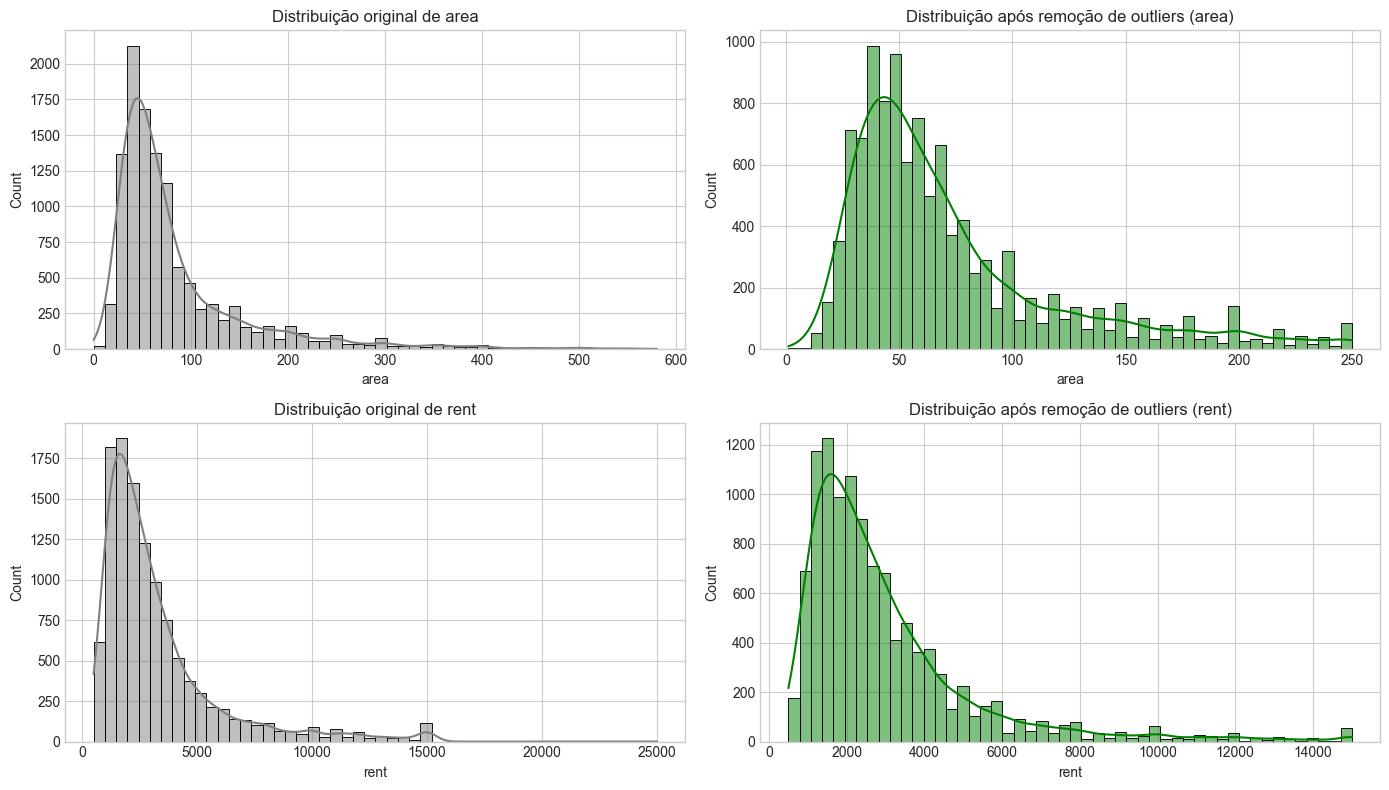

In [37]:
# Gera os gráficos com dois pares lado a lado
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

for i, col in enumerate(['area', 'rent']):
    sns.histplot(df[col], bins=50, kde=True, ax=axs[i][0], color='gray')
    axs[i][0].set_title(f'Distribuição original de {col}')
    
    sns.histplot(df_model[col], bins=50, kde=True, ax=axs[i][1], color='green')
    axs[i][1].set_title(f'Distribuição após remoção de outliers ({col})')

plt.tight_layout()
plt.show()

## 6. Modelagem Preditiva

O objetivo deste capítulo é aplicar diferentes algoritmos de regressão para prever o valor mensal dos aluguéis (`rent`), com base nas variáveis preditoras selecionadas.  
O processo de modelagem será conduzido em etapas:
- 1. Divisão dos dados em conjuntos de treino e teste;
- 2. Treinamento de um modelo baseline, como a Regressão Linear Múltipla;
- 3. Avaliação de desempenho preditivo do modelo baseline, por meio de métricas como $\text{RMSE}$, $\text{MAE}$ e $R²$;
- 4. Comparação entre modelos (Árvore de Regressão, Random Forest e Gradient Boosting);
- 5. Técnicas de validação cruzada, regularização e ajuste de hiperparâmetros;
- 6. Interpretação dos resultados, incluindo análise de resíduos e importância das variáveis.

### 6.1. Divisão em treino e teste

Utilizamos a função `train_test_split` da biblioteca `sklearn`, para separar o conjunto de dados em:
- 70% para treino, utilizado para ajuste dos modelos;
- 30% para teste, reservado para avaliação de desempenho preditivo.  

A divisão foi estratificada com base na variável-alvo `rent`, após garantir que todas as etapas do pré-processamento já haviam sido executadas.

In [38]:
# Define as variáveis preditoras (X) e alvo (y)
X = df_model.drop(columns = ['encargos', 'rent', 'total'])
y = df_model['rent']

# Divide em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 79)

# Verifica os tamanhos
print(f"Tamanho do conjunto de treino: {X_train.shape}.")
print(f"Tamanho do cojunto de teste: {X_test.shape}.")

Tamanho do conjunto de treino: (7823, 252).
Tamanho do cojunto de teste: (3354, 252).


### 6.2. Regressão Linear Múltipla com `statsmodels`

Iniciamos o processo de modelagem preditiva com uma **Regressão Linear Múltipla**, que atuará como modelo baseline, utilizando a biblioteca `statsmodels`, em razão de sua robustez e capacidade de fornecer estatísticas detalhada sobre o modelo ajustado.  
A especificação do modelo, segundo a sintaxe do `statsmodels`, segue a forma

\begin{equation*}
\text{rent} \sim \text{area} + \text{bedrooms} + \text{garage} + \text{C(district)} + \text{C(type)}.
\end{equation*}

In [39]:
# Adiciona o intercepto a design matrix X
X_model = sm.add_constant(X)

# Cria o modelo OLS
ols_model = sm.OLS(y, X_model).fit()
y_pred = ols_model.predict(X_model)

# Sumário do modelo OLS
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rent   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     72.19
Date:                Mon, 28 Jul 2025   Prob (F-statistic):               0.00
Time:                        12:22:27   Log-Likelihood:                -96808.
No. Observations:               11177   AIC:                         1.941e+05
Df Residuals:                   10924   BIC:                         1.960e+05
Df Model:                         252                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                         772.3590    207.116      3.729      0.000     366.374    1178.344
area                                           21.6651      0.570     38.005      0.000      20.548      22.783
bedrooms                                       44.5163     29.906      1.489      0.137     -14.106     103.138
garage                                        544.9934     26.962     20.213      0.000     492.142     597.845
district_Alphaville                          1605.0301    663.898      2.418      0.016     303.670    2906.391
district_Alphaville Empresarial              2404.6002    382.481      6.287      0.000    1654.868    3154.332
district_Alphaville Industrial               1055.2316    328.176      3.215      0.001     411.948    1698.516
district_Alto da Lapa                         772.0746    428.674      1.801      0.072     -68.203    1612.353
district_Alto da Mooca                         25.3525    321.905      0.079      0.937    -605.639     656.344
district_Alto de Pinheiros                   1806.8563    455.606      3.966      0.000     913.786    2699.926
district_Americanópolis                      -349.4822    472.748     -0.739      0.460   -1276.153     577.189
district_Barra Funda                          530.5393    255.381      2.077      0.038      29.946    1031.133
district_Bela Vista                           486.4452    216.098      2.251      0.024      62.854     910.036
district_Belenzinho                           437.8068    324.594      1.349      0.177    -198.457    1074.071
district_Bom Retiro                            35.6308    335.176      0.106      0.915    -621.375     692.637
district_Bosque da Saúde                       65.9362    357.555      0.184      0.854    -634.936     766.808
district_Brooklin                            2865.3714    352.517      8.128      0.000    2174.374    3556.369
district_Brooklin Paulista                   1483.5700    301.634      4.918      0.000     892.314    2074.826
district_Brás                                 -76.1063    234.675     -0.324      0.746    -536.112     383.900
district_Butantã                              606.8863    292.464      2.075      0.038      33.605    1180.168
district_Cambuci                              -77.1483    245.130     -0.315      0.753    -557.648     403.352
district_Campestre                           -452.5470    390.067     -1.160      0.246   -1217.148     312.054
district_Campo Belo                          1267.9934    249.145      5.089      0.000     779.624    1756.363
district_Campos Elíseos                      -329.0331    240.990     -1.365      0.172    -801.417     143.351
district_Casa Verde                           167.6046    3

In [40]:
# Métricas principais
r2 = ols_model.rsquared
r2_adj = ols_model.rsquared_adj
aic = ols_model.aic
bic = ols_model.bic
f_stat = ols_model.fvalue
p_val = ols_model.f_pvalue

# Métricas de erro
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

print('\nAvaliação do Modelo com rent (sem log):')
print(f'R²: {r2:.3f} → Explica aproximadamente {r2*100:.1f}% da variabilidade nos valores de aluguel.')
print(f'R² ajustado: {r2_adj:.3f}')
print(f'AIC: {aic:.0f}, BIC: {bic:.0f}')
print(f'Estatística F: {f_stat:.2f} (p-valor: {p_val:.4f})')

print('\nMétricas de Erro:')
print(f'MAE (erro absoluto médio): R$ {mae:,.2f}')
print(f'MSE (erro quadrático médio): {mse:,.2f}')
print(f'RMSE (raiz do erro quadrático médio): R$ {rmse:,.2f}')


Avaliação do Modelo com rent (sem log):
R²: 0.625 → Explica aproximadamente 62.5% da variabilidade nos valores de aluguel.
R² ajustado: 0.616
AIC: 194122, BIC: 195974
Estatística F: 72.19 (p-valor: 0.0000)

Métricas de Erro:
MAE (erro absoluto médio): R$ 883.50
MSE (erro quadrático médio): 1,952,893.64
RMSE (raiz do erro quadrático médio): R$ 1,397.46


### 6.2.1 Avaliação do modelo

O modelo de regressão linear múltipla foi ajustado com o valor do aluguel (`rent`) como variável dependente, utilizando variáveis como `area`, `bedrooms`, `garage`, `districts`, entre outras.

### Métricas de Qualidade do Ajuste:

- **R² = 0.625**: O modelo explica cerca de 62,5% da variabilidade no valor do aluguel, o que representa um desempenho razoável, considerando a diversidade e complexidade dos imóveis na cidade de São Paulo, mas que pode ser melhorado.
- **R² ajustado = 0.616**: Ajusta o R² levando em conta o número de variáveis preditoras, mantendo uma performance próxima ao R² simples, o que indica que o modelo não está excessivamente sobreajustado.
- **AIC = 194.122** e **BIC = 195.974**: Indicadores de qualidade do modelo penalizando complexidade.
- **F-statistic = 72.19** com p-valor < 0.001: O modelo é estatisticamente significativo como um todo.

### Métricas de Erro:

- **MAE (erro absoluto médio)**: R$ 883,50.
- **MSE (erro quadrático médio)**: R$ 1.952.893,64.
- **RMSE (raiz do erro quadrático médio)**: R$ 1.397,46.

Esses valores indicam que, em média, as previsões do modelo estão distantes do valor real por quase R$ 900, e a raiz do erro quadrático aponta para desvios padrão médios de cerca de R$ 1.400, o que pode ser aceitável em faixas de aluguel mais elevadas, mas elevado para imóveis mais baratos.

### Conclusão:

Apesar de o modelo ser estatisticamente significativo e apresentar um R² razoável, os erros absolutos e quadráticos ainda são altos, o que pode indicar a presença de heterocedasticidade e assimetria. Isso reforça a necessidade de testar um modelo log-transformado (com transformação logarítmica da variável dependente), para tentar melhorar o desempenho preditivo e a distribuição dos resíduos, reduzindo o impacto de outliers.

### 6.3. Modelo Log-transformado

Com o objetivo de mitigar os efeitos da heterocedasticidade e da assimetria da variável resposta, aplicamos log à variável `rent`, passando a modelar a relação entre as variáveis preditoras e `log_rent`.  
A nova especificação do modelo será dada por:

\begin{equation*}
\log(\text{rent}) \sim \text{area} + \text{bedrooms} + \text{garage} + \text{C(district)} + \text{C(type)}.
\end{equation*}

Esse modelo log-linear será avaliado por meio de métricas como o R² ajustado, AIC, BIC, MAE, MSE e RMSE (convertidas de volta à escala original para interpretação), permitindo uma comparação direta com o modelo base. Também discutiremos os ganhos em termos de qualidade ajustada e comportamento dos resíduos.

In [41]:
# Cria a variável log-transformada da variável 'rent'
df_model['log_rent'] = np.log(df_model['rent'])

# Define X e y para o modelo log-transformado
X_log = df_model.drop(columns = ['encargos', 'rent', 'total', 'log_rent'])
X_log = sm.add_constant(X_log)
y_log = df_model['log_rent']

# Cria o modelo OLS log-transformado
model_log = sm.OLS(y_log, X_log).fit()
y_pred_log = model_log.predict(X_log)

# Sumári do modelo OLS log-transformado
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_rent   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     106.1
Date:                Mon, 28 Jul 2025   Prob (F-statistic):               0.00
Time:                        12:22:27   Log-Likelihood:                -3610.3
No. Observations:               11177   AIC:                             7727.
Df Residuals:                   10924   BIC:                             9579.
Df Model:                         252                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                           7.1432      0.050    144.204      0.000       7.046       7.240
area                                            0.0050      0.000     36.760      0.000       0.005       0.005
bedrooms                                        0.0609      0.007      8.514      0.000       0.047       0.075
garage                                          0.1109      0.006     17.197      0.000       0.098       0.124
district_Alphaville                             0.3540      0.159      2.229      0.026       0.043       0.665
district_Alphaville Empresarial                 0.4685      0.091      5.122      0.000       0.289       0.648
district_Alphaville Industrial                  0.3370      0.078      4.294      0.000       0.183       0.491
district_Alto da Lapa                           0.0305      0.103      0.297      0.766      -0.170       0.231
district_Alto da Mooca                         -0.0294      0.077     -0.382      0.703      -0.180       0.122
district_Alto de Pinheiros                      0.3650      0.109      3.349      0.001       0.151       0.579
district_Americanópolis                        -0.3744      0.113     -3.312      0.001      -0.596      -0.153
district_Barra Funda                            0.1834      0.061      3.002      0.003       0.064       0.303
district_Bela Vista                             0.1486      0.052      2.875      0.004       0.047       0.250
district_Belenzinho                             0.0918      0.078      1.182      0.237      -0.060       0.244
district_Bom Retiro                             0.0509      0.080      0.634      0.526      -0.106       0.208
district_Bosque da Saúde                        0.0010      0.086      0.012      0.991      -0.167       0.169
district_Brooklin                               0.5589      0.084      6.629      0.000       0.394       0.724
district_Brooklin Paulista                      0.3658      0.072      5.070      0.000       0.224       0.507
district_Brás                                  -0.0610      0.056     -1.087      0.277      -0.171       0.049
district_Butantã                                0.2031      0.070      2.903      0.004       0.066       0.340
district_Cambuci                               -0.0322      0.059     -0.549      0.583      -0.147       0.083
district_Campestre                             -0.1499      0.093     -1.607      0.108      -0.333       0.033
district_Campo Belo                             0.2719      0.060      4.563      0.000       0.155       0.389
district_Campos Elíseos                        -0.1906      0.058     -3.306      0.001      -0.304      -0.078
district_Casa Verde                             0.0808     

In [42]:
# Função que automatiza o cálculo de métricas de avaliação
def calculate_metrics(model, y_true, y_pred) -> dict:
    """
    Calcula métricas de avaliação para um modelo de regressão.
    
    Parâmetros:
    - model: objeto do modelo ajustado.
    - y_true: valores reais da variável dependente.
    - y_pred: valores preditos pelo modelo.
    
    Retorna:
    - Um dicionário com as métricas calculadas.
    """
    r2 = model.rsquared
    r2_adj = model.rsquared_adj
    aic = model.aic
    bic = model.bic
    f_stat = model.fvalue
    p_val = model.f_pvalue
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return {
        'R²': r2,
        'R² Ajustado': r2_adj,
        'AIC': aic,
        'BIC': bic,
        'Estatística F': f_stat,
        'p-valor': p_val,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    }
    
calculate_metrics(model_log, y_log, y_pred_log)

{'R²': np.float64(0.7098937322596748),
 'R² Ajustado': np.float64(0.7032014236300005),
 'AIC': np.float64(7726.53479104731),
 'BIC': np.float64(9578.90297476687),
 'Estatística F': np.float64(106.0760600776753),
 'p-valor': np.float64(0.0),
 'MAE': 0.2571097044781504,
 'MSE': 0.11170879732524945,
 'RMSE': np.float64(0.33422866023913844)}

In [43]:
print('\nAvaliação do Modelo com log_rent:')
print(f'R²: {model_log.rsquared:.3f} → Explica aproximadamente {model_log.rsquared*100:.1f}% da variabilidade nos valores de aluguel.')
print(f'R² ajustado: {model_log.rsquared_adj:.3f}')
print(f'AIC: {model_log.aic:.0f}, BIC: {model_log.bic:.0f}')
print(f'Estatística F: {model_log.fvalue:.2f} (p-valor: {model_log.f_pvalue:.4f})')

print('\nMétricas de Erro:')
print(f'MAE (erro absoluto médio): R$ {mean_absolute_error(np.exp(y_log), np.exp(y_pred_log)):,.2f}')
print(f'MSE (erro quadrático médio): {mean_squared_error(y_log, y_pred_log):.2f}')
print(f'RMSE (raiz do erro quadrático médio): R$ {np.sqrt(mean_squared_error(y_log, y_pred_log)):,.2f}')


Avaliação do Modelo com log_rent:
R²: 0.710 → Explica aproximadamente 71.0% da variabilidade nos valores de aluguel.
R² ajustado: 0.703
AIC: 7727, BIC: 9579
Estatística F: 106.08 (p-valor: 0.0000)

Métricas de Erro:
MAE (erro absoluto médio): R$ 1,306.20
MSE (erro quadrático médio): 0.11
RMSE (raiz do erro quadrático médio): R$ 0.33


### 6.3.1. Avaliação do modelo

O modelo de regressão linear múltipla foi ajustado utilizando a transformação logarítmica do valor do aluguel (`log_rent`) como variável dependente. Essa abordagem tem como objetivo mitigar o impacto de outliers, estabilizar a variância dos resíduos e melhorar a aderência aos pressupostos da regressão linear, mantendo as mesmas variáveis explicativas consideradas anteriormente.

### Métricas de Qualidade do Ajuste:

- **R² = 0.710**: O modelo explica aproximadamente 71,0% da variabilidade no log do valor do aluguel, representando um bom ganho de desempenho em relação ao modelo original. Isso indica uma melhor capacidade de capturar os padrões subjacentes dos dados.
- **R² ajustado = 0.703**: Mantém um valor elevado, próximo ao R² simples, indicando que o modelo está bem ajustado, mesmo levando em consideração a quantidade de variáveis preditoras.
- **AIC = 7.727** e **BIC = 9.579**: Reduções expressivas em relação ao modelo anterior, o que evidencia melhora na qualidade do ajuste com menor penalização por complexidade.
- **F-statistic = 106.08** com p-valor < 0.001: O modelo é altamente significativo do ponto de vista estatístico.

### Métricas de Erro:

- **MAE (erro absoluto médio)**: R$ 1.306,20  
- **MSE (erro quadrático médio)**: 0.11 (escala logarítmica)
- **RMSE (raiz do erro quadrático médio)**: 0.33 (escala logarítmica)

O MAE indica que, em média, o erro nas previsões do aluguel real gira em torno de R$ 1.300, valor compatível com os níveis observados no mercado. Já o RMSE e o MSE são apresentados na escala logarítmica, pois sua reversão para a escala original resultaria em métricas distorcidas devido à sensibilidade a valores extremos.

### Conclusão:

O modelo com `log_rent` como variável dependente apresentou melhorias consistentes em todas as métricas de avaliação. A transformação logarítmica contribuiu para reduzir a influência de valores extremos, melhorando a explicação da variabilidade e estabilizando os resíduos. Trata-se, portanto, de uma alternativa estatisticamente e interpretativamente mais robusta em relação ao modelo com `rent` sem transformação, e será a base para os próximos aprimoramentos.

### 6.3.2. Interpretação dos coeficientes

O modelo ajustado com `log_rent` como variável resposta possui a seguinte equação estimada:

\begin{equation*}
\log(\text{rent}) = 7.1432 + 0.0050 \cdot \text{area} + 0.0609 \cdot \text{bedrooms} + 0.1109 \cdot \text{garage} + 0.0009 \cdot \text{price\_per\_m2} + 0.1285 \cdot \text{has\_garage} + \cdots
\end{equation*}

A previsão do aluguel é obtida fazendo

\begin{equation*}
\text{rent} = \exp(\log(\text{rent})).
\end{equation*}

Como a variável dependente está em escala logarítmica, os coeficientes indicam variações percentuais aproximadas. A cada unidade adicional em uma variável $x_j$, mantendo as demais constantes, o valor de `rent` é multiplicado por $\exp(\beta_j)$. A variação percentual correspondente é:

\begin{equation*}
\left(e^{\beta_j} - 1\right) \cdot 100\%.
\end{equation*}

**Exemplos**:
- `intercepto` ($\beta_0 = 7.1432$) → valor esperado de $\log(\text{rent})$ no nível de referência;
- `area` ($\beta_1 = 0.0050$) → aumento de **0.50%** no aluguel por m² adicional;
- `bedrooms` ($\beta_2 = 0.0609$) → aumento de **6.28%** por dormitório adicional;
- `garage` ($\beta_3 = 0.1109$) → aumento de **11.73%** por vaga de garagem;
- `price_per_m2` ($\beta_4 = 0.0009$) → aumento de **0.09%** a cada R$/m² a mais;
- `has_garage` ($\beta_5 = 0.1285$) → imóveis com garagem têm, em média, **13.71%** a mais de aluguel.

Essas interpretações assumem que as demais variáveis permanecem constantes.

### 6.4. Pressupostos do modelo log-linear

### 6.4.1. Normalidade dos resíduos

A suposição de normalidade dos resíduos é fundamental para que os testes de significância dos coeficientes da regressão sejam válidos. Nesta subseção, avaliaremos essa suposição visualmente e estatisticamente, a partir dos resíduos do modelo ajustado com `log_rent` como variável dependente.

Serão utilizados:
- **Histograma com curva KDE** para avaliar a forma da distribuição dos resíduos;
- **QQ-plot** para comparar os quantis empíricos dos resíduos com os de uma distribuição normal padrão;
- **Teste de Shapiro-Wilk**, que testa a hipótese nula de que os resíduos seguem uma distribuição normal.

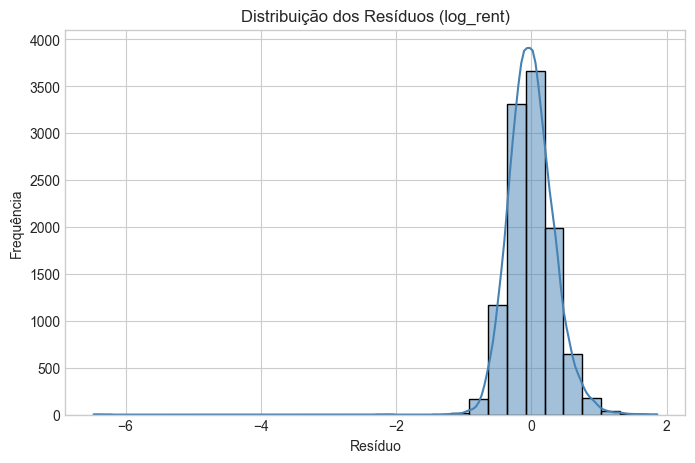

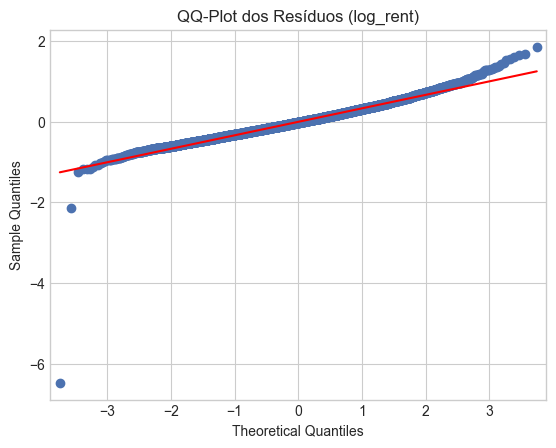

Estatística de Shapiro-Wilk: 0.9691
p-valor: 0.0000
Os resíduos provavelmente NÃO seguem uma distribuição normal (p < 0.05).


c:\environments\DS_env\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11177.
  res = hypotest_fun_out(*samples, **kwds)


In [44]:
# Resíduos do modelo log
residuals_log = y_log - y_pred_log

# Histograma com KDE dos resíduos
plt.figure(figsize = (8, 5))
sns.histplot(residuals_log, kde = True, bins = 30, color = 'steelblue')
plt.title('Distribuição dos Resíduos (log_rent)')
plt.xlabel('Resíduo')
plt.ylabel('Frequência')
plt.show()

# QQ-plot
sm.qqplot(residuals_log, line = 's')
plt.title('QQ-Plot dos Resíduos (log_rent)')
plt.show()

# Teste de Shapiro-Wilk
shapiro_stat, shapiro_p = stats.shapiro(residuals_log)
print(f"Estatística de Shapiro-Wilk: {shapiro_stat:.4f}")
print(f"p-valor: {shapiro_p:.4f}")

if shapiro_p < 0.05:
    print("Os resíduos provavelmente NÃO seguem uma distribuição normal (p < 0.05).")
else:
    print("Os resíduos provavelmente seguem uma distribuição normal (p ≥ 0.05).")

Apesar de o modelo log-transformado apresentar bom desempenho preditivo ($R^2 = 0{,}71$), a violação da suposição de normalidade dos resíduos indica que os intervalos de confiança e os testes de hipótese sobre os coeficientes podem não ser totalmente confiáveis.

No entanto, essa suposição é crucial apenas para inferência estatística, e **não é crucial para a validade do modelo como ferramenta preditiva**. Conforme destacado em discussões como [esta no StackExchange](https://stats.stackexchange.com/questions/100214/assumptions-of-linear-models-and-what-to-do-if-the-residuals-are-not-normally-di), a normalidade dos resíduos não afeta a consistência nem a imparcialidade dos estimadores de mínimos quadrados. Além disso, com um grande número de observações ($n > 11\,000$), o Teorema Central do Limite tende a mitigar esses efeitos.

Portanto, o modelo segue sendo adequado para previsão. 


### 6.4.2. Homocedasticidade dos resíduos

A homocedasticidade, ou variância constante dos resíduos, é uma das principais suposições da regressão linear. Quando essa condição é violada (isto é, ocorre heterocedasticidade), os erros não possuem variância constante, o que pode comprometer a validade dos testes estatísticos e levar a inferências incorretas.

Para verificar essa suposição, adotamos duas abordagens:
- Análise visual do gráfico de resíduos vs valores ajustados, que pode revelar padrões ou funis típicos de heterocedasticidade;
- **Teste de Breusch-Pagan**, um teste estatístico formal que avalia a presença de heterocedasticidade nos resíduos.

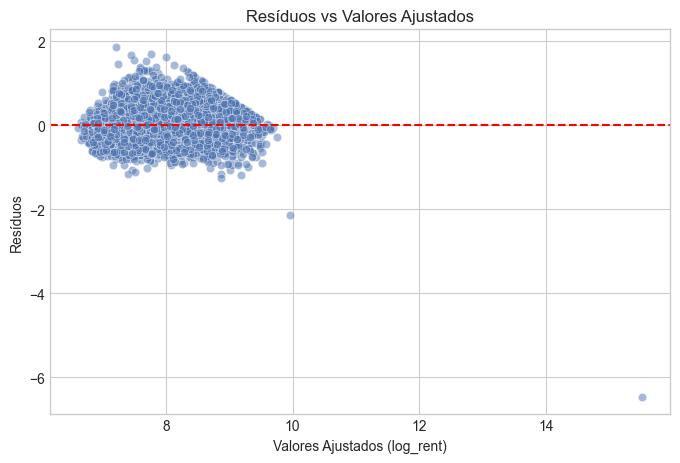

Estatística LM: 9063.3059
p-valor: 0.0000
Estatística F: 185.8770
p-valor F: 0.0000
Heterocedasticidade detectada (p < 0.05).


In [45]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Valores ajustados do modelo
fitted_vals = y_pred_log
residuals = y_log - y_pred_log

# Gráfico: resíduos vs valores ajustados
plt.figure(figsize = (8, 5))
sns.scatterplot(x = fitted_vals, y = residuals, alpha = 0.5)
plt.axhline(0, color = 'red', linestyle = '--')
plt.title('Resíduos vs Valores Ajustados')
plt.xlabel('Valores Ajustados (log_rent)')
plt.ylabel('Resíduos')
plt.show()

# Teste de Breusch-Pagan
bp_test = het_breuschpagan(residuals, X_model)
bp_labels = ['Estatística LM', 'p-valor', 'Estatística F', 'p-valor F']
for name, value in zip(bp_labels, bp_test):
    print(f'{name}: {value:.4f}')

if bp_test[1] < 0.05:
    print("Heterocedasticidade detectada (p < 0.05).")
else:
    print("Não há evidência de heterocedasticidade (p ≥ 0.05).")


O teste de Breusch-Pagan indicou **heterocedasticidade significativa** (p < 0.0001), ou seja, os resíduos não apresentam variância constante. Isso viola uma das suposições da regressão linear e pode comprometer a precisão dos erros padrão, p-valores e intervalos de confiança.

Como o foco está na performance preditiva, iremos testar modelos não lineares mais robustos, que não exigem a suposição de homocedasticidade, como Árvores de Regressão, Random Forest e Gradient Boosting. Esses modelos são menos sensíveis a violações de pressupostos e podem oferecer previsões mais precisas em cenários com heterocedasticidade.

### 6.4.3. Verificação de multicolinearidade

A multicolinearidade ocorre quando duas ou mais variáveis preditoras estão fortemente correlacionadas entre si. Isso pode tornar os coeficientes instáveis e dificultar a interpretação dos efeitos individuais das variáveis.

Para detectar multicolinearidade, utilizamos o **Fator de Inflação da Variância** (VIF - *Variance Inflation Factor*). Esse indicador quantifica o quanto a variância de um coeficiente é aumentada devido à correlação com outras variáveis explicativas.

- **VIF > 5**: indica possível multicolinearidade;
- **VIF > 10**: multicolinearidade severa.

Nesta análise, consideramos apenas as variáveis numéricas, dado que variáveis categóricas dummies com muitas categorias podem inflar artificialmente os VIFs.

In [46]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Seleciona apenas as variáveis numéricas usadas no modelo
X_vif = df_model[['area', 'bedrooms', 'garage', 'price_per_m2', 'has_garage']]

# Adiciona o intercepto
X_vif = sm.add_constant(X_vif)

# Calcula o VIF para cada variável
vif_data = pd.DataFrame()
vif_data['Variável'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# Exibe os resultados
display(vif_data)


,Variável,VIF
0,const,7.31
1,area,2.91
2,bedrooms,2.31
3,garage,3.61
4,price_per_m2,1.02
5,has_garage,2.38


O VIF foi calculado para as variáveis numéricas do modelo. Os resultados foram:

| Variável       | VIF  |
|----------------|------|
| `const`        | 7.31 |
| `area`         | 2.91 |
| `bedrooms`     | 2.31 |
| `garage`       | 3.61 |
| `price_per_m2` | 1.02 |
| `has_garage`   | 2.38 |

Nenhuma variável apresentou VIF superior a 10, o limite adotado para identificar multicolinearidade severa. Mesmo considerando um critério mais conservador (limite de 5), todos os valores estão abaixo do ponto de atenção.

O maior VIF foi o da variável `garage` (3.61), indicando uma correlação moderada com outras variáveis, mas sem comprometer a estabilidade do modelo.

Portanto, não há indícios de multicolinearidade relevante, e não é necessário remover variáveis com base no VIF neste momento.


### Conclusão:  

As análises diagnósticas mostraram que:

- A suposição de **normalidade dos resíduos** foi violada (Shapiro-Wilk);
- A suposição de **homocedasticidade** também foi violada (Breusch-Pagan);
- **Não foi detectada multicolinearidade** relevante (VIF < 5 para todas as variáveis).

Apesar das violações, o modelo permanece válido para fins preditivos. Como próximos passos, testaremos **modelos não lineares mais robustos**, como Árvores de Regressão, Random Forest e Gradient Boosting, que não exigem essas suposições e podem capturar relações mais complexas entre as variáveis.


## 7. Modelos Não Lineares

### 7.1. Regressão com modelos baseados em árvores

In [48]:
# Função para avaliar o modelo de regressão
def evaluate_model(nome, modelo, X_train, y_train, X_test, y_test) -> dict:
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"-- {nome.title()} --")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print()
    
    return {'Modelo': nome, 'R²': r2, 'RMSE': rmse, 'MAE': mae}

In [67]:
resultados = []

# Decision Tree
tree_model = DecisionTreeRegressor(random_state = 79)
resultados.append(evaluate_model('Decision Tree', tree_model, X_train, y_train, X_test, y_test))
tree_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestRegressor(random_state = 79)
resultados.append(evaluate_model('Random Forest', rf_model, X_train, y_train, X_test, y_test))
rf_model.fit(X_train, y_train)

# Gradient Boosting
gb_model = GradientBoostingRegressor(random_state = 79)
resultados.append(evaluate_model('Gradient Boosting', gb_model, X_train, y_train, X_test, y_test))
gb_model.fit(X_train, y_train)

# Resultados em DataFrame
resultados_df = pd.DataFrame(resultados)

-- Decision Tree --
R²: 0.9934
RMSE: 182.8747
MAE: 67.4499

-- Random Forest --
R²: 0.9966
RMSE: 131.3207
MAE: 35.5802

-- Gradient Boosting --
R²: 0.9916
RMSE: 205.6685
MAE: 116.4757



In [68]:
resultados_df

,Modelo,R²,RMSE,MAE
0,Decision Tree,0.99,182.87,67.45
1,Random Forest,1.00,131.32,35.58
2,Gradient Boosting,0.99,205.67,116.48


In [69]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer 

kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
neg_mse_scores = cross_val_score(rf_model, X_model, y_log, scoring = 'neg_mean_squared_error', cv = kf)
r2_scores = cross_val_score(rf_model, X_model, y_log, scoring = 'r2', cv = kf)

print("RMSE médio (CV):", (- neg_mse_scores.mean()) ** 0.5)
print("R² médio (CV):", r2_scores.mean())

RMSE médio (CV): 0.03298546599520725
R² médio (CV): 0.9971780206413037


C:\Users\ricar\AppData\Local\Temp\ipykernel_20220\4054590405.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'Importância', y = 'Variável', data = top_features.sort_values(by = 'Importância'), palette = 'viridis')


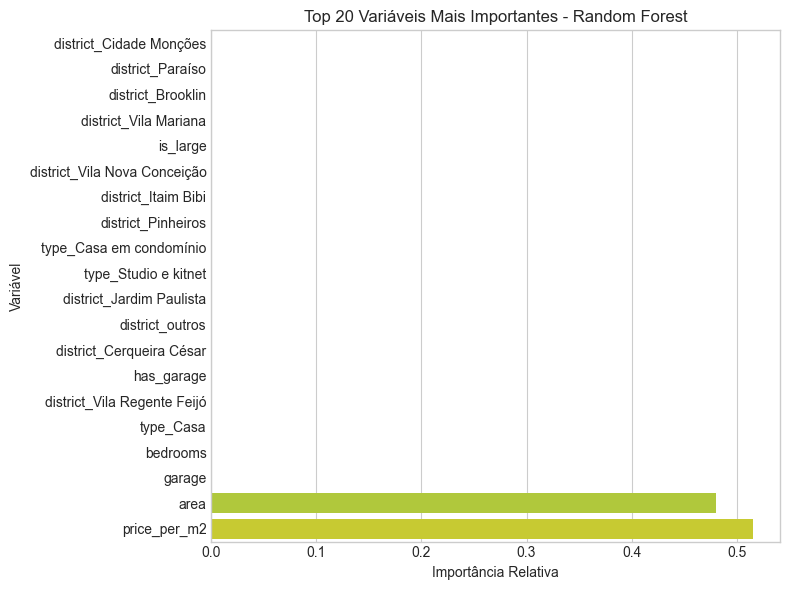

In [83]:
# Importância das variáveis no modelo Random Forest
import matplotlib.pyplot as plt
import seaborn as sns

# Extrai a importância das variáveis
importances = rf_model.feature_importances_
features = X_train.columns

# Organiza em DataFrame para melhor visualização
feature_importance = pd.DataFrame({
    'Variável': features,
    'Importância': importances
}).sort_values(by = 'Importância', ascending = True)
top_features = feature_importance.sort_values(by = 'Importância', ascending = False).head(20)

# Gráfico
plt.figure(figsize = (8, 6))
sns.barplot(x = 'Importância', y = 'Variável', data = top_features.sort_values(by = 'Importância'), palette = 'viridis')
plt.title('Top 20 Variáveis Mais Importantes - Random Forest')
plt.xlabel('Importância Relativa')
plt.ylabel('Variável')
plt.tight_layout()
plt.show()

C:\Users\ricar\AppData\Local\Temp\ipykernel_20220\3936069536.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importância', y = 'Variável', data = perm_df.head(20), palette = 'cividis')


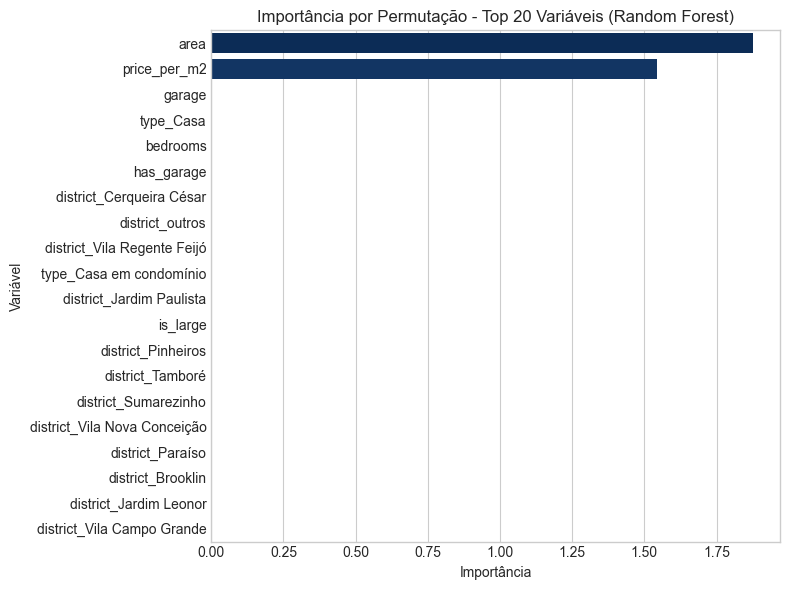

In [84]:
from sklearn.inspection import permutation_importance

# Importância por permutação (usando X_train)
result = permutation_importance(rf_model, X_train, y_train, n_repeats = 10, random_state = 79)
importances_perm = result.importances_mean

# Cria o DataFrame
perm_df = pd.DataFrame({
    'Variável': X_train.columns,
    'Importância': importances_perm
}).sort_values(by='Importância', ascending = False)

# Gráfico
plt.figure(figsize = (8, 6))
sns.barplot(x = 'Importância', y = 'Variável', data = perm_df.head(20), palette = 'cividis')
plt.title('Importância por Permutação - Top 20 Variáveis (Random Forest)')
plt.tight_layout()
plt.show()

In [85]:
top_vars_5 = ['area', 'price_per_m2', 'garage', 'type_Casa', 'bedrooms']

X_model_5 = X_model[top_vars_5]

evaluate_model('Random Forest (5 Variáveis)', rf_model, X_train[top_vars_5], y_train, X_test[top_vars_5], y_test)

-- Random Forest (5 Variáveis) --
R²: 0.9963
RMSE: 136.1120
MAE: 32.2702



{'Modelo': 'Random Forest (5 Variáveis)',
 'R²': 0.9963376160529676,
 'RMSE': np.float64(136.11199359986347),
 'MAE': 32.270190816935006}

In [ ]:
# Avaliação do modelo Random Forest com as 5 variáveis mais importantes
def avaliar_modelo(X, y, nome_modelo):
    rf = RandomForestRegressor(random_state = 79)
    kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
    r2_scores = cross_val_score(rf, X, y, cv = kf, scoring = 'r2')
    rmse_scores = (- cross_val_score(rf, X, y, cv = kf, scoring = 'neg_mean_squared_error')) ** 0.5

    print(f'\nModelo: {nome_modelo}')
    print(f'R² médio (CV): {r2_scores.mean():.4f}')
    print(f'RMSE médio (CV): {rmse_scores.mean():.4f}')

# Aplicar
avaliar_modelo(X_model_5, y_log, "Random Forest (Top 5 variáveis)")


Modelo: Random Forest (Top 5 variáveis)
R² médio (CV): 0.9974
RMSE médio (CV): 0.0304
